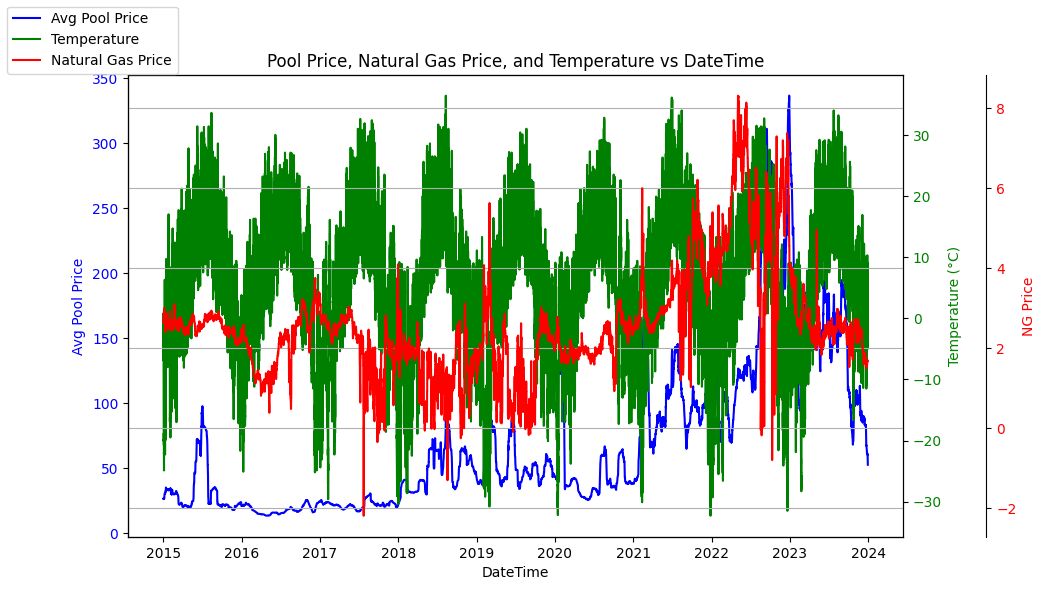

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
data = pd.read_csv('Calgary_merged_expanded_data_with_generator.csv', parse_dates=['DateTime'])

# Create a single plot with separate y-axes for temperature and NG price
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Pool Price
ax1.plot(data['DateTime'], data['rolling_30day_avg'], label='Avg Pool Price', color='blue')
ax1.set_xlabel('DateTime')
ax1.set_ylabel('Avg Pool Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the temperature
ax2 = ax1.twinx()
ax2.plot(data['DateTime'], data['Temp (°C)'], label='Temperature', color='green')
ax2.set_ylabel('Temperature (°C)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Create a third y-axis for the NG price
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the right spine of ax3
ax3.plot(data['DateTime'], data['NG_price'], label='Natural Gas Price', color='red')
ax3.set_ylabel('NG Price', color='red')
ax3.tick_params(axis='y', labelcolor='red')

# Add a legend with custom handles
handles, labels = [], []
for ax in [ax1, ax2, ax3]:
    for h, l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)
fig.legend(handles, labels, loc='upper left')

plt.title("Pool Price, Natural Gas Price, and Temperature vs DateTime")
plt.grid(True)
plt.show()

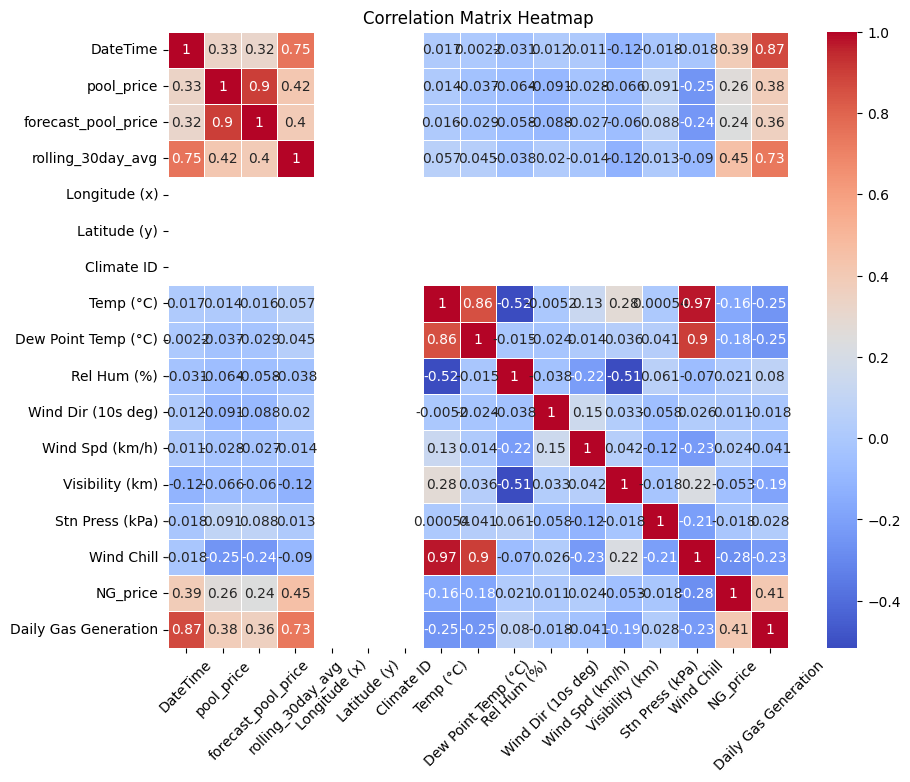

In [11]:
correlation_matrix = data.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Customize the plot (optional)
plt.title("Correlation Matrix Heatmap")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()